step 1 run roscore to prevent losing of training data

step 2 roslaunch turtlebot3_gazebo turtlebot3_simple.launch

In [1]:
import rospy as ros
import os
from sensor_msgs.msg import LaserScan
import numpy as np
from numpy import Inf
from geometry_msgs.msg import Twist, Pose
from nav_msgs.msg import Odometry
from std_srvs.srv import Empty
from gazebo_msgs.srv import SpawnModel
import random
from math import atan2, pi
import matplotlib.pyplot as plt

Author: Abdulrahman Altahhan, Jan 2023.

The notebook use a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard python libraries (numpy, matplotlib etc.).
Please note that you will need to take a permission from the author to use the code for research, commercially or otherwise.

# Lesson 11: RL on Robotics

**Learning outcomes**
1. understand how to create a simple Robot environment that links to Gazebo
1. understand how to deal with the simulated environment in a grid world fashion
1. appreciate the intricacy of applying RL to the robotics domain
1. build on previous concepts to come up with a suitable solution to a problem at hand
1. understand how a replay buffer helps us to come closer to supervised learning and appreciate the important role it plays in reaching convergence
1. understand how to combine deep reinforcement learning with deep learning to create a powerful framework that allows automatic agent learning by observation or self-play.
1. understand how a replay buffer helps us to come closer to supervised learning and appreciate the important role it plays in reaching convergence for difficult problems that involve image processing and reinforcement learning


**Reading**:
We cover applications of RL on robotics based on previouse units which you can refere to.

In this notebook, we deal with how to set up a robot environment class that can handle the publish-subscribe on topics and deal with services in ROS. We must have ROS and Gazebo installed and set up on our machine. The code is a starting point and is not fully developed. You will need to write the necessary functionality to address a specific requirement. The main idea of tackling robotics applications in a Jupyter notebook is to utilise the provided infrastructure and libraries of code we covered in earlier units.

## Running Gazebo
You will need to launch a gazebo environment with Turtlebot3 in it. So long as the /scan(LaserScan), /odom (Odometry) and /cmd_vel(Twist) topics are available, the environment should work fine. Our target is to build an environment that will allow us to use the algorithms we developed in earlier units directly.

To launch an environment, you should open a terminal and run the following command

roslaunch turtlebot3_gazebo turtlebot3_house.launch

Note that you cannot do that here because that will block the notebook from executing other code. 
You must select restart your notebook kernel, ex. Kernel-> Restart and Run ALL, whenever you want to re-establish a connection with the environment.


In [2]:
%matplotlib inline

In [3]:
import rospy as ros
from sensor_msgs.msg import LaserScan
import numpy as np
from numpy import Inf
from geometry_msgs.msg import Twist
from nav_msgs.msg  import Odometry
from std_srvs.srv import Empty
import random
from math import pi

In [4]:
# global hyperparamter how many areas full cricle divided
θres = 10
# global hyperparamter how times publisher publisehs
hz = 5

In [36]:
class RoboGridEnv:
    
    # the goals default values are set just in front of the robot for testing, 
    # change according to the brief and as you see fit
    def __init__(self, xdim=4, ydim=4, hz=hz,  
                 xgoal=1.3, ygoal=0, tol=0.5,
                 speed=0.3, θspeed=1,
                 resol=3, θresol=2*pi/θres,
                 range_min=0.30,
                 rewards=[100, -10, 0, -1,],
                 visual=False):
        
        ros.init_node('RoboEnv')
        ros.loginfo('Robot Environment node has been created')
        
        self.sub_scan = ros.Subscriber('/scan', LaserScan, self.scan, queue_size=None)
        self.sub_odom = ros.Subscriber('/odom', Odometry, self.odom, queue_size=1)
        self.pub_robot = ros.Publisher('/cmd_vel', Twist, queue_size=1)
        
        self.Vstar = None # for compatibility
        
        #visual
        self.visual = visual
        
        # coordinates of the goal must be changed to match the given environment
        self.xgoal = xgoal
        self.ygoal = ygoal
        
        #size of env         
        self.xdim = xdim
        self.ydim = ydim
        
                 
        # $ rostopic hz /scan, rostopic hz /odom
        self.hz = hz  # frequency of scan
        self.rate = ros.Rate(self.hz)
        
        self.speed = speed    # linear speed, change as you see fit
        self.θspeed = θspeed # angular speed, change as you see fit
        self.tol = tol     # tolerance to goal recognition, within 2 feet
        
        self.resol = round(resol,2)
        self.θresol = round(θresol,2)
        
        self.cols = int(self.xdim//self.resol) +1
        self.rows = int(self.ydim//self.resol) +1
        self.orts = int(2*pi//self.θresol)     +1
        
        self.x = None
        self.y = None
        self.θ = None
        self.scans = None
        

        self.nC = self.rows*self.cols           # Grid size
        self.nS = self.rows*self.cols*self.orts # State space size
        self.nA = 3
        
        self.range_max = 3.5
        self.range_min = .25  # change as you see fit
        
        print('Grid  size = ', self.rows,'x', self.cols,'=', self.nC)
        print('State size = ', self.rows,'x', self.cols, 'x', self.orts,'=',self.nS)
        
        self.robot = Twist()

    # change as you see fit
    def scan(self, scans):
        scans = np.array(scans.ranges)
        scans[scans==Inf] = self.range_max
        # print('scans = ', scans[:10].round(2))
        self.scans = scans
        self.rate.sleep()
    
    # change the reward to produce a suitable policy
    def reward(self):
        reward = -1
        done = False
        
        # cheacking for goal
        tol = self.tol 
        if self.xgoal + tol > self.x > self.xgoal - tol and self.ygoal + tol > self.y > self.ygoal - tol: 
            reward =  100 
            done = True
        
        # add code to make your robot stops when it hit a wall
        
        return reward, done
    
    # change as you see fit
    def odom(self, odoms):
        self.x = round(odoms.pose.pose.position.x, 1)   
        self.y = round(odoms.pose.pose.position.y, 1)   

        self.rate.sleep() 
    
    # change this to generate a suitable state representation
    def s_(self):
         # the return is provided for testing only
         # you must return the state of the robot instead
        return random.randint(0, self.nS)
    
    def reset(self):
#         reset_world service
        try:    ros.ServiceProxy('/gazebo/reset_world', Empty).call()
        except: print('could not reset world')
        self.rate.sleep()
        self.done = False
        return self.s_()

    def step(self, a):
        
        # commented out for testing
        if a==0: self.left(self.θspeed)
        if a==1: self.forward()
        if a==2: self.right(self.θspeed)
            
#         self.forward() # comment this out, as it will force the robot always to move forward
        
        self.s = self.s_() # get the stat
        self.r, self.done = self.reward()
        return self.s, self.r, self.done, {}
    
    def nodeslist(self):
        nodes = os.popen('rosnode list').readlines()
        for i in range(len(nodes)):
            nodes[i] = nodes[i].replace('\n', '')
            print(nodes[i])
    
    # for compatibility, no need to change
    def render(self, **kw):
        pass
    
    def left(self, θspeed):
        self.robot.linear.x  =  0
        self.robot.angular.z = θspeed
        self.pub_robot.publish(self.robot)
        self.rate.sleep()
    def forward(self):
        self.robot.linear.x  = self.speed
        self.robot.angular.z =  0
        self.pub_robot.publish(self.robot)
        self.rate.sleep()
    def right(self, θspeed):
        self.robot.linear.x  =  0
        self.robot.angular.z =-θspeed
        self.pub_robot.publish(self.robot)
        self.rate.sleep()
    def stop(self):
        self.robot.linear.x = 0
        self.robot.angular.z = 0
        self.pub_robot.publish(self.robot)
        self.rate.sleep()

In [37]:
robogrid2x2 = RoboGridEnv(xdim=4, ydim=4,
                          xgoal=1.5, ygoal=0, tol =0.6,
                          speed=0.2, θspeed=1, hz=hz,
                          resol=0.4, θresol=(2*pi/θres),
                          range_min=0.38)

[INFO] [1682629561.690200, 73.363000]: Robot Environment node has been created
Grid  size =  10 x 10 = 100
State size =  10 x 10 x 10 = 1000


In [ ]:
def revolve(env):
    env.visual = True
    env.reset()
    env.step(-1)
    for i in range(15):
        env.step(0)
        env.stop()
        plt.pause(1)
        
    env.visual = False
revolve(robogrid2x2)

In [45]:
def straight(env):
    env.visual = True
    env.reset()
    done = False
    
    while not done:
        done = env.step(1)[2]
    
    env.stop()
    env.visual= False
        
straight(robogrid2x2)

## Training Headless
To train more efficiently, turn off the gui in gazebo. To do so, go to the .launch file that you have launched gazebo with and set the values of gui and headless as follows:

    <arg name="gui" value="false"/>
    <arg name="headless" value="true"/>

Now it is time to apply Sarsa on robotics! Note that this will not generate a useful policy yet. You must adjust the above code and tune your RL method hyperparameters.

In [76]:
import nbimporter
from Lesson5_TemporalDifferenceMethods import *

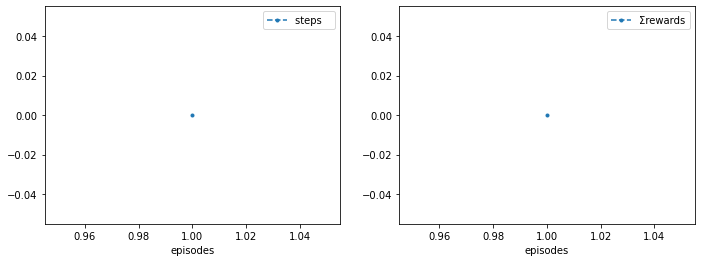

In [80]:
env=RoboGridEnv()
sarsa = Sarsa(env=env, α=.1, episodes=10, seed=10, **demoGame()).interact()
env.stop()

Continue by adding more cells to address the requirements

In [1]:
import rospy as ros
import numpy as np
from numpy import Inf
from geometry_msgs.msg import Twist
from nav_msgs.msg  import Odometry
from std_srvs.srv import Empty
from time import sleep
import math
from sensor_msgs.msg import LaserScan

class Env:
    def __init__(self):hz
        ros.init_node('Env')
        ros.loginfo('Env node has been created')
        self.sub_odom = ros.Subscriber('/odom', Odometry, self.odom_callback, queue_size=1)
        self.pub_robot = ros.Publisher('/cmd_vel', Twist, queue_size=1)
        # self.sub_scan = ros.Subscriber('/scan', LaserScan, self.scan, queue_size=None)
        
        # $ rostopic hz /scan
        # $ rostopic hz /odom
        self.rate = ros.Rate(5) # 5 is the frequency of scan (we can reduce here to reduce the overhead but responsiveness will degrade)
        self.robot = Twist()
        
        # Initialize position and orientation variables
        self.x = 0.0
        self.y = 0.0
        self.θ = 0.0
        
        self.current_yaw = 0
        self.max_increase = 0.45
        self.z_rotate = 0

        self.range_max = 3.5
        self.range_min = .25 # extra safty buffer to stop a bit early

    def step(self, a):
        if a==1:
            self.rotate('down')
        if a==0:
            self.rotate('right')
        if a==3:
            self.rotate("up")
        if a==2:
            self.rotate("left")
        
        self.forward(a)
            
        self.pub_robot.publish(self.robot)
        self.rate.sleep()
    
    def scan(self, scans):
        scans = np.array(scans.ranges)
        scans[scans==Inf] = self.range_max
        print('scans = ', scans[:10].round(2))
           
        self.done = scans.min() < self.range_min
        # if scans[:3].min() < self.range_min or scans[-3:].min() < self.range_min:
        #     self.left()

        self.scans = scans
        self.pub_robot.publish(self.robot)
        self.rate.sleep()

    def forward(self, a):
    # Move the robot forward for one second
        increase = 0.4
        if (a==0):
            increase = 0.6
    
        self.robot.linear.x = 0.14 * (increase + self.max_increase)
        self.robot.angular.z = 0 
        self.pub_robot.publish(self.robot)

    # Sleep for one second
        sleep(1)

    # Stop the robot
        self.robot.linear.x = 0
        self.robot.angular.z = 0
        self.pub_robot.publish(self.robot)
    
    def normalize_angle(self, angle):
        while angle > math.pi:
            angle -= 2 * math.pi
        while angle < -math.pi:
            angle += 2 * math.pi
        return angle
    
    def rotate(self, direction):
        if direction == 'down':
            target_yaw = 0
        elif direction == 'left':
            target_yaw = math.radians(90)
        elif direction == 'up':
            target_yaw = math.radians(180)
        elif direction == 'right':
            target_yaw = math.radians(270)
        else:
            raise ValueError('Invalid direction, must be "down", "left", "up", or "right".')

        angle_tolerance = 0.015  # Adjust this value based on the required precision
        angular_velocity = 0.14  # rad/s, set this to the desired angular velocity

        target_yaw = self.normalize_angle(target_yaw)
        current_yaw_normalized = self.normalize_angle(self.current_yaw)

        while abs(current_yaw_normalized - target_yaw) > angle_tolerance:
            clockwise_angle_diff = (current_yaw_normalized - target_yaw) % (2 * math.pi)
            counterclockwise_angle_diff = (target_yaw - current_yaw_normalized) % (2 * math.pi)

            if clockwise_angle_diff < counterclockwise_angle_diff:
                self.robot.angular.z = -angular_velocity  # Rotate clockwise
            else:
                self.robot.angular.z = angular_velocity  # Rotate counterclockwise

            self.pub_robot.publish(self.robot)
            self.rate.sleep()
            current_yaw_normalized = self.normalize_angle(self.current_yaw)

        self.robot.angular.z = 0  # Stop rotating

    def odom_callback(self, odoms):
        self.z = round(odoms.pose.pose.orientation.z, 3)
        self.w = round(odoms.pose.pose.orientation.w, 3)
        self.current_yaw = math.atan2(2 * (self.w * self.z), 1 - 2 * (self.z**2))
    
    def stop(self):
        self.robot.linear.x = 0
        self.robot.angular.z = 0
        self.pub_robot.publish(self.robot)
        self.rate.sleep()
    
    def resetPos(self):
        # Initialize position and orientation variables
        self.x = 0.0
        self.y = 0.0
        self.θ = 0.0

        self.odom_prev = None

    def reset(self):
        self.done = False
        # reset_world service
        # $ rosservice list
        # $ rosservice info /gazebo/reset_world
        # $ rossrv show std_srvs/Empty # yeilds nothing meaning we can call() without passing arguemnt
        try:
            ros.ServiceProxy('/gazebo/reset_world', Empty).call()
        except:
            print('could not reset world')

finished


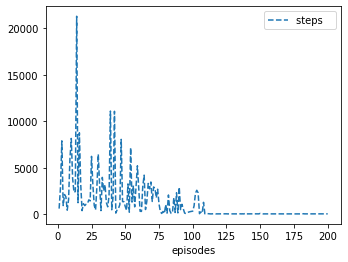

In [2]:
from matplotlib import colors
from IPython.display import clear_output
import time
import random
from numpy.random import rand, seed, randint, choice
from random import choices, sample
import matplotlib.pyplot as plt
import numpy as np

env = Env()
env.reset()

rows = 35
cols = 35

obstacles = [
    *list(range(0, 2+(rows-1)*cols, cols)),
    *list(range(1, 2+(rows-1)*cols, cols)),
    *list(range(34, -2+(rows+1)*cols, cols)),
    *list(range(33, -2+(rows+1)*cols, cols)),
    *list(range(0, 34)),
    *list(range(35, 69)),
    *list(range(1190, 1224)),
    *list(range(1155, 1189)),
    *list(range(630, 639)),
    *list(range(665, 674)),
    *list(range(700, 709)),
    *list(range(1028, 1039)),
    *list(range(993, 1004)),
    *list(range(958, 969)),
    *list(range(574, 583)),
    *list(range(539, 548)),
    *list(range(504, 513)),
    *list(range(251, 260)),
    *list(range(286, 295)),
    *list(range(321, 330)),
    *list(range(271, 279)),
    *list(range(306, 314)),
    *list(range(341, 349)),
    *list(range(880, 2+(rows-1)*cols, cols)),
    *list(range(881, 2+(rows-1)*cols, cols)),
    *list(range(882, 2+(rows-1)*cols, cols)),
    *list(range(727, 1077, cols)),
    *list(range(728, 1078, cols)),
    *list(range(729, 1079, cols)),
    *list(range(20, 300, cols)),
    *list(range(19, 299, cols)),
    *list(range(18, 298, cols))
]

class Grid:
    def __init__(self, gridsize=[35,35], nA=4, s0=720, goals=[1052, 134], Vstar=None):
        self.rows = gridsize[0]
        self.cols = gridsize[1]
        self.nS = self.cols*self.rows # we assume cells IDs go left to right and top down
        self.goals = [self.nS-1, self.nS-1] if goals is None else ([goals[0], goals[0]] if len(goals)==1 else goals)
        self.Vstar = Vstar # optimal state value, needed for some of the environments
        self.s0 = s0
        self.s = s0
        self.trace = [self.s0]
        
        # actions ---------------------------------------------------------------------       
        cols = self.cols
        self.actions_2 = [-1, +1]
        self.actions_4 = [-1, +1, -cols, +cols]     # left, right, down and up
        self.actions_8 = [-1, +1, -cols, +cols, -1-cols, -1+cols, 1-cols, 1+cols] # left-down, left-up, right-down, right-up
 
        self.nA = nA
        if nA==2: self.actions = self.actions_2
        if nA==4: self.actions = self.actions_4
        if nA==8: self.actions = self.actions_8
        
        # rewards types-----------------------------------------------------------------
        self.nR = 4
        self.rewards = [0, 1, 0, -100] # intermediate, goal1, goal2, cliff
        self.obstacles, self.cliffs = [], [] # lists that will be checked when doing actions
        
        
    def reset(self, withtrace=True):
        self.s = self.s0
        if withtrace: self.trace = [self.s0]
        return self.s_()
    #-----------------------------------------rewards related-------------------------------------------
    def rewards_set(self):
        return np.array(list(set(self.rewards)))
        
    def reward(self):
        stype = self.stype()
        reward = self.rewards[stype]
        if stype==3: self.reset(False)    # s in cliffs
        return reward, 2>=stype>=1        # either at goal1 or goal2
    
    #-----------------------------------------actions related-------------------------------------------
    def invalid(self, s,a):
        cols = self.cols
        # invalid moves are 
        # 1. off grid boundaries
        # 2. off the right edge (last and is for right up and down diagonal actions)
        # 3. off the left edge  (last and is for left  up and down diagonal actions)
        # 4. into an obstacle
        return      not(0<=(s+a)<self.nS) \
                    or (s%cols!=0 and (s+a)%cols==0 and (a==1 or a==cols+1 or a==-cols+1))  \
                    or (s%cols==0 and (s+a)%cols!=0 and (a==-1 or a==cols-1 or a==-cols-1)) \
                    or (s+a) in self.obstacles

    def step(self, a, *args):
        a = self.actions[a]
        if not self.invalid(self.s,a): self.s += a
        
        self.trace.append(self.s)
        reward, done = self.reward()       # must be done in this order for the cliff reset to work properly
        return self.s_(), reward, done, {} # empty dict for compatibility
    
    #-----------------------------------------state related-------------------------------------------
    # useful for inheritance, observation can be a state (index) or a state representation (vector or image)
    def s_(self):
        return self.s
    
    # returns the number of states that are available for the agent to occupy
    def nS_available(self):
        return self.nS - len(self.obstacles)
    
    #-----------------------------------------goals related-------------------------------------------
    # returns the type of the current state (0: intermediate, 1 or 2 at goal1 or goal2, 3:off cliff)
    def stype(self):
        s, goals, cliffs = self.s, self.goals, self.cliffs
        # the order is significant and must not be changed
        return [s not in goals+cliffs, s==goals[0], s==goals[1], s in cliffs].index(True)
    
    def isatgoal(self):
        return self.stype() in [1,2] # either at goal1 or goal2

class Grid(Grid):
    def __init__(self, pause=0, figsize=None, **kw):
        super().__init__(**kw)
        
        self.figsize = figsize # desired figure size        
        self.fig = None        # figure handle, may have several subplots        
        self.ax0 = None        # Grid subplot handle
        
        self.pause = pause     # pause to slow animaiton
        self.arrows = None     # policy arrows (direction of action with max value)
        
        # assuming env is not dynamic, otherwise should be moved to render() near self.to_pos(self.s)
        self.start = self.to_pos(self.s0)         
        self.goal1 = self.to_pos(self.goals[0])
        self.goal2 = self.to_pos(self.goals[1])
        self.cmap = colors.ListedColormap(['w', 'darkgray'])

    # state representation function that converts 1-d list of state representation into a 2-d coordinates
    def to_pos(self, s):
        return [s%self.cols + 1, s//self.cols + 1]

    #------------------------------------------initialise------------------------------------------------- 
    def init_cells(self, cells): 
        Cells = np.zeros((self.rows+1, self.cols+1),  dtype=bool)
        Cells[0,0] = True # to populate for drawing 
        poses = self.to_pos(np.array(cells))
        Cells[poses[1], poses[0]] = True
        return Cells[1:,1:]
    
    #------------------------------------------render ✍️-------------------------------------------------
    # this function is to protect render() called twice for Gridi
    def render(self, **kw):
        self.render__(**kw)

    # we have placed most of the render overhead in the render() function to keep the rest efficient.
    # this funciton must not be called directly instead render() is to be called
    def render__(self, underhood='', pause=None, label='', subplot=131, large=False, 
               animate=True, image=False, saveimg=False,  **kw):
        
        if self.figsize is None:
            if   self.rows==1:             self.figsize = (15,.5) 
            elif underhood=='Q':           self.figsize = (20, 10)
            elif underhood=='V' and large: self.figsize = (30, 25)
            else:                          self.figsize = (17, 3)
        if image: self.figsize = (17, 3) # changing the default figure size is dissallowed for games

        if self.fig is None: self.fig = plt.figure(1)
        #if self.ax0 is None: self.ax0 = plt.subplot(subplot)
        plt.gcf().set_size_inches(self.figsize[0], self.figsize[1])
            
        #if   animate: self.ax0 = plt.subplot(subplot)
        #elif image:   plt.cla() 
        self.ax0 = plt.subplot(subplot)
        if image and not animate: plt.cla()
           
        
        # get hooks for self properties
        rows, cols = self.rows, self.cols
        pos, start, goal1, goal2 = self.to_pos(self.s), self.start, self.goal1, self.goal2
        
        pause = self.pause if pause is None else pause
        
        # a set of properties for the grid subplot
        
        prop = {'xticks': np.linspace(0, cols, cols+1),     'xticklabels':[],
                'yticks': np.linspace(0, rows, rows+1)+.01, 'yticklabels':[],
                'xlim':(0, cols), 'ylim':(0, rows), 'xlabel': label} # useful info
        self.ax0.update(prop)
        self.ax0.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
        if self.style not in ['maze', 'cliff']: self.ax0.grid(True)

        # robot visuals :-)
        mrgn = .5
        eyes = '˚-˚' if underhood!='Q' else '' 
        body = 'ro'  if underhood!='Q' else 'co'
        
        # plot goals and start state
        for (x,y), s in zip([goal1, goal2, start], ['G', 'G', 'S']):
            self.ax0.text(x-mrgn, y-mrgn, s, fontsize=20)
        
        # plot robot
        self.ax0.text(pos[0]-mrgn-.2, pos[1]-mrgn-.15, eyes, fontsize=10)
        self.ax0.plot(pos[0]-mrgn,    pos[1]-mrgn,     body, markersize=15) 
        #self.ax0.plot(pos, body, markersize=15) # this causes the body not be up to date in later lessons

        # to reduce overhead, pre-store coordinates in the grid only when render is needed
        if self.X is None: 
            self.X, self.Y = np.array(self.to_pos(np.arange(self.nS))) 
            self.Ox, self.Oy = np.arange(cols+1), np.arange(rows+1)

        # underhood obstacles and a cliffs
        if self.style=='maze':  
            if self.Obstacles is None: self.Obstacles = self.init_cells(self.obstacles)
            self.ax0.pcolormesh(self.Ox, self.Oy, self.Obstacles, edgecolors='lightgray', cmap=self.cmap)
        
        # this means that the user wants to draw the policy arrows (actions)
        if 'Q' in kw and underhood=='': underhood='maxQ'
        
        # a placeholder function for extra rendering jobs
        render_ = getattr(self, 'render_'+ underhood)(**kw)
        # windy style needs a bespoke rendering
        if self.style =='windy': self.render_windy()

        if image: self.render_image(saveimg=saveimg)
            
        # to animate clear and plot the Grid
        if animate: clear_output(wait=True); plt.show(); time.sleep(pause)
        #else: plt.subplot(subplot)
    
    #-------------------------helper functions for rendering policies and value functions---------------------
    def render_(self, **kw):
        pass # a placeholder for a another drawing if needed
    
    def render_image(self, **kw):
        pass # a placeholder for capturing and saving Grid as images
    
    # renders all states numbers' reprsentation on the grid
    def render_states(self, **kw):
        X,Y  = self.X, self.Y
        for s in range(self.nS): 
            self.ax0.text(X[s]-.5,Y[s]-.5, s, fontsize=13, color='g')

class Grid(Grid):
    def __init__(self, reward='',  style='', **kw):
        super().__init__(**kw)
    
        # explicit rewards for[intermediate,goal0,goal1, cliff] states
        self.reward_    = [0,    1,   0, -100] # this is the default value for the rewards
        self.randwalk   = [ 0,   0,   1,    0]
        self.randwalk_  = [ 0,  -1,   1,    0]
        self.reward0    = [-1,   0,   0,   -1]
        self.reward_1   = [-1,  -1,  -1,   -1]
        self.reward1    = [-1,   1,   1,   -1]
        self.reward10   = [-1,  10,  10,   -1]
        self.reward100  = [-1, 100, 100,   -1]
    
        if reward: self.rewards  = getattr(self, reward)
        self.style = style
        
        # accommodating grids styles -------------------------------------------------------------
        self.X, self.Y = None, None
        self.Obstacles = self.Cliffs = 0 # np arrays for display only, related to self.obstacles, self.cliffs
        self.wind = [0]*10               # [0,0,0,0,0,0,0,0,0,0]
        
        if self.style=='maze':
            self.Obstacles = None        # for displaying only, to be filled when render() is called
            rows = self.rows
            cols = self.cols
            midc = int(cols/2)
            
            ## WALLS
            #######################
            #######################
            #######################
            # Assign the obstacles list to the instance variable
            self.obstacles = obstacles
        # upward winds intensity for each column
        elif self.style=='windy':
            self.wind = [0,0,0,1,1,1,2,2,1,0] # as in example 6.5 of the book
    
    # override the step() function so that it can deal with wind
    def step(self, a, *args):
        a = self.actions[a]
        if not self.invalid(self.s,a): self.s += a
        
        if self.style=='windy':
            maxwind = self.wind[self.s%self.cols]
            for wind in range(maxwind, 0, -1): # we need to try apply all the wind or at least part of it
                if not self.invalid(self.s, wind*self.cols): self.s += wind*self.cols; break
        
        self.trace.append(self.s)
        reward, done = self.reward()       # must be done in this order for the cliff reset to work properly
        return self.s_(), reward, done, {} # empty dict for compatibility
    
    def render_maxQ(self, Q=None, **kw): 
        if Q is None: Q=np.ones((self.nS, self.nA ))
        X, Y = self.X, self.Y
        if self.arrows is None: self.init_arrows()
        U, Z = self.arrows[np.argmax(Q,1)].T
        ind  = np.sum(Q,1)!=0
        if ind.any()==False: return
        plt.quiver(X[ind]-.5,Y[ind]-.5,  U[ind],Z[ind],color='b')
        
        
    def init_arrows(self):       
        self._left,      self._right,   self._down,       self._up       = tuple(range(0,4))
        self._left_down, self._left_up, self._right_down, self._right_up = tuple(range(4,8))
        
        # works for quiver and pos, max action can potentially go upto 8! if we are dealing with a grid world
        self.arrows = np.zeros((self.nA,2), dtype=int)
        
        self.arrows[self._left ] =[-1, 0]  # '←'
        self.arrows[self._right] =[ 1, 0]  # '→'
        
        if self.nA>2:
            self.arrows[self._down ] =[ 0,-1]  # '↓'
            self.arrows[self._up   ] =[ 0, 1]  # '↑'

        if self.nA>4:
            self.arrows[self._left_down ]=[-1,-1]  # '↓←'
            self.arrows[self._left_up   ]=[-1, 1]  # '↑←'
            self.arrows[self._right_down]=[ 1,-1]  # '→↓'
            self.arrows[self._right_up  ]=[ 1, 1]  # '→↑

class MRP:
    
    def __init__(self, env=Grid(style='maze'), γ=1, α=.1, v0=0, episodes=100, view=1, 
                 store=False, # Majority of methods are pure one-step online and no need to store episodes trajectories 
                 max_t=2000, seed=None, visual=False, underhood='', 
                 last=10, print_=False):
                

        # hyper parameters
        self.env = env
        self.γ = γ
        self.α = α # average methods(like MC1st) do not need this but many other methods (like MCα) do
        self.v0 = v0
        self.episodes = episodes
        self.store = store
        self.max_t = max_t
        self.visual = visual
        self.view = view
        self.underhood = underhood
        self.last = last
        self.print = print_

        # reference to two important functions
        self.policy = self.stationary
        self.step = self.step_a
        # we might want to skip a step
        self.skipstep = False
        
        nA = self.env.nA
        self.As = list(range(nA))
        self.pAs = [1/nA]*nA
        
        # useful to repeate the same experiement
        self.seed(seed)
        # to protect interact() in case of no training 
        self.ep = -1 
        
    # set up important metrics
    def init_metrics(self):
        self.Ts = np.zeros(self.episodes, dtype=np.uint32)
        self.Rs = np.zeros(self.episodes)
        self.Es = np.zeros(self.episodes)  
        self.inds = np.ones (self.episodes, dtype=bool)
        
    # set up the V table
    def init_(self):
        self.V = np.ones(self.env.nS)*self.v0

    
    # useful for inheritance, gives an expected return (value) for state s
    def V_(self, s=None): 
        return self.V  if s is None else self.V[s]
    
    def seed(self, seed=None, **kw):
        if seed is not None: np.random.seed(seed); random.seed(seed)
    #-------------------------------------------buffer related-------------------------------------------------
    # The buffer get reinitialised by reinitialising t only but we have to be careful not to exceed t+1 at any time
    def allocate(self): 
        if not self.store: return
        self.r = np.zeros(self.max_t)
        self.s = np.ones(self.max_t, dtype=np.uint32)*(self.env.nS+10) # states are indices:*(nS+10)for debugging 
        self.a = np.ones(self.max_t, dtype=np.uint32)*(self.env.nA+10) #actions are indices:*(nA+10)for debugging       
        self.done = np.zeros(self.max_t, dtype=bool)
    
    def store_(self, s=None,a=None,rn=None,sn=None,an=None, done=None, t=0):
        if not self.store: return
        
        if s  is not None: self.s[t] = s
        if a  is not None: self.a[t] = a
        if rn is not None: self.r[t+1] = rn
        if sn is not None: self.s[t+1] = sn
        if an is not None: self.a[t+1] = an
        if done is not None: self.done[t+1] = done
    
    def stop_ep(self, done):
        return done or (self.store and self.t+1 >= self.max_t-1) # goal reached or storage is full
    
    # ------------------------------------ experiments related --------------------------------------------
    def stop_exp(self):
        if self.stop_early(): print('experience stopped at episode %d'%self.ep); return True
        return self.ep == self.episodes - 1

    #----------------------------------- 🐾steps as per the algorithm style --------------------------------
    def step_0(self):
        s = self.env.reset()                                 # set env/agent to the start position
        a = self.policy(s)
        return s,a
    
    # accomodates Q-learning and V style algorithms
    def step_a(self, s,_, t):                          
        if self.skipstep: return 0, None, None, None, True
        a = self.policy(s)
    
        sn, rn, done, _ = self.env.step(a)
    
        # we added s=s for compatibility with deep learning
        self.store_(s=s, a=a, rn=rn, sn=sn, done=done, t=t)
    
        # None is returned for compatibility with other algorithms
        return rn,sn, a,None, done
    
    # accomodates Sarsa style algorithms
    def step_an(self, s,a, t):                          
        if self.skipstep: return 0, None, None, None, True
        sn, rn, done, _ = self.env.step(a)

        an = self.policy(sn)
        # env.step(a)
        # print(self.episodes)
        
        # we added s=s for compatibility with deep learning later
        self.store_(s=s, a=a, rn=rn, sn=sn, an=an, done=done, t=t)
        return rn,sn, a,an, done
    
    #------------------------------------ 🌖 online learning and interaction --------------------------------
    def interact(self, train=True, grid_img=False, **kw):
        if train:
            self.init_()
            self.init()                                     # user defined init() before all episodes
            self.init_metrics()
            self.allocate()
            self.plot0()                                    # useful to see initial V values
            self.seed(**kw)
            self.ep = -1 #+ (not train)*(self.episodes-1)
            self.t_ = 0                                     # steps counter for all episodes
        
        #for self.ep in range(self.episodes):
        while not self.stop_exp():
            self.ep += 1
            self.t  = -1                                    # steps counter for curr episode
            self.Σr = 0
            done = False
            # initial step
            s,a = self.step_0()
            self.step0()                                    # user defined init of each episode
            # an episode is a set of steps, interact and learn from experience, online or offline.
            while not self.stop_ep(done):
        
                # take one step
                self.t += 1
                self.t_+= 1
                
                rn,sn, a,an, done = self.step(s,a, self.t)  # takes a step in env and store tarjectory if needed
                self.online(s, rn,sn, done, a,an) # to learn online, pass a one step trajectory

                if self.ep == 199:
                    print(self.t)
                    print(a)
                    env.step(a)
                
                self.Σr += rn
                self.rn = rn
                s,a = sn,an
                
                # render last view episodes, for games ep might>episodes
                if self.visual and self.episodes > self.ep >= self.episodes-self.view: self.render(**kw)

            # to learn offline and plot episode
            self.metrics()
            self.offline()
            self.plot_ep()
            
    
        # plot experience   
        self.plot_exp(**kw)
        
        return self  
    #------------------------------------- policies types 🧠-----------------------------------
        
    def stationary(self, *args):
        #return choice(self.As, 1, p=self.pAs)[0] # this gives better experiements quality but is less efficient
        return choices(self.As, weights=self.pAs, k=1)[0] if self.env.nA!=2 else np.random.binomial(1, 0.5)
    
    #---------------------------------------perfromance metrics📏 ------------------------------
    def metrics(self):
        # we use %self.episodes so that when we use a different criterion to stop_exp() code will run
        self.Ts[self.ep%self.episodes] = self.t+1
        self.Rs[self.ep%self.episodes] = self.Σr
        self.Es[self.ep%self.episodes] = self.Error()
        
        if self.print: print(self)
    
    def __str__(self):
        # mean works regardless of where we stored the episode metrics (we use %self.episodes)
        ep, episodes = self.ep, self.episodes
        i, inds = ep%episodes, self.inds.copy()
        last = min(ep+1, self.last) # display last 10 episodes or so
        inds[i+1: episodes+1-(last-i)] = False # turn off indexes that we do not want, to deal with circular indexes
        
        metrics = 'step %d, episode %d, r %.2f, mean r last %d ep %.2f, ε %.2f'
        values = (self.t_, ep, self.Rs[i], last, self.Rs[inds][-last:].mean().round(2), round(self.ε, 2))

        return metrics%values

    #------------------------functions that can be overridden in the child class-----------------
    def init(self):
        pass
    def step0(self):
        pass
    def Error(self):
        return 0
    def stop_early(self):
        return False
    def plot0(self):
        pass
    def plot_t(self):
        pass
    def plot_ep(self):
        pass
    def plot_exp(self, *args):
        pass
    def offline(self):
        pass
    def online(self,*args):
        pass
    #---------------------------------------visualise ✍️----------------------------------------
    # overload the env render function
    def render(self, rn=None, label='', **kw):
        if rn is None: rn=self.rn
        param = {'V':self.V_()} if self.underhood=='V' else {}
        self.env.render(**param, 
                        label=label+' reward=%d, t=%d, ep=%d'%(rn, self.t+1, self.ep+1), 
                        underhood=self.underhood, 
                        **kw)

class MRP(MRP):
    
    def __init__(self, plotV=False,  plotT=False, plotR=False, plotE=False, animate=False, Vstar=None, **kw):
        super().__init__(**kw)
        
        # visualisation related
        self.plotT = plotT
        self.plotR = plotR
        self.plotE = plotE
        self.plotV = plotV 
        self.animate = animate
        self.eplist = []
        
        nS = self.env.nS
        self.Vstar = Vstar if Vstar is not None else self.env.Vstar
    #------------------------------------------- metrics📏 -----------------------------------------------  
    # returns RMSE but can be overloaded if necessary
    # when Vstar=0, it shows how V is evolving via training 
    def Error(self):
        if self.Vstar is None: return 0
        return np.sqrt(np.mean(((self.V_() - self.Vstar)[1:-1])**2)) #if self.Vstar is not None else 0
    
    #--------------------------------------------visualise ✍️----------------------------------------------

    def plot0(self):
        if self.plotV: self.plot_V(); plt.show()
        
    def plot_exp(self, label='', **kw):
        self.plot_ep(animate=True, plot_exp=True, label=label)
        
    def plot_ep(self, animate=None, plot_exp=False, label=''): 
        if len(self.eplist)< self.episodes: self.eplist.append(self.ep+1)
            
        if animate is None: animate = self.animate
        if not animate: return
        frmt='.--'if not plot_exp or self.ep==0 else '--'
 
        if self.visual: 
            if self.ep==self.episodes-1: self.render(animate=False) # shows the policy 
            else:                        self.env.render(animate=False) 
        if self.plotV:  self.plot_V(ep=self.ep+1)        
        
        i=2
        for plot, ydata, label_ in zip([self.plotT, self.plotR, self.plotE], 
                                      [self.Ts,    self.Rs,    self.Es   ], 
                                      ['steps   ', 'Σrewards', 'Error   ']):
            if not plot: continue
            plt.subplot(1,3,min(i,3)).plot(self.eplist[:self.ep+1], ydata[:self.ep+1], frmt, label=label_+label)
            plt.xlabel('episodes')
            plt.legend()
            i+=1

        if self.visual or self.plotV or self.plotT or self.plotR or self.plotE:
            figsize = plt.gcf().get_size_inches()
            plt.gcf().set_size_inches(max(figsize[0],18), figsize[1])
            clear_output(wait=True)
            if not plot_exp: plt.show()


    def plot_V(self, ep=0):
        
        self.env.ax0 = plt.subplot(1,3,1) # to add this axis next to a another axis to save some spaces
        plt.gcf().set_size_inches(18, 3)
        
        # get letter as state names if no more than alphabet else just give them numbers
        letters = self.env.letters_list()[1:-1] if self.env.nS<27 else list(range(self.env.nS-2))
        
        # plot the estimated values against the optimal values
        plt.plot(letters, self.V_()[1:-1], '.-', label='V episode=%d'%(ep)) # useful for randwalk
        plt.plot(letters, self.Vstar[1:-1],'.-k')
        
        # set up the figure
        plt.xlabel('State', fontsize=16)
        plt.legend()
        plt.title('Estimated value for %d non-terminal states'%(self.env.nS-2), fontsize=16)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)

def MDP(MRP=MRP):
    class MDP(MRP):
        def __init__(self, env=Grid(style='maze'), commit_ep=0, ε=.1, εmin=0.01, dε=1, εT=0, q0=0, Tstar=0, **kw): 

            super().__init__(env=env, **kw)
            # set up hyper parameters
            self.ε = ε 
            self.ε0 = ε  # store initial 
            self.dε = dε # for exp decay
            self.εT = εT # for lin decay
            self.εmin = εmin
            
            # override the policy to εgreedy to make control possible
            self.policy = self.εgreedy

            # initial Q values
            self.q0 = q0

            # which episode to commit changes
            self.commit_ep = commit_ep
            
            # number of steps for optimal policy
            self.Tstar = Tstar
            
        # set up the Q table
        def init_(self):
            super().init_() # initialises V
            self.Q = np.ones((self.env.nS,self.env.nA))*self.q0
        
        #------------------------------------- add some more policies types 🧠-------------------------------
        # useful for inheritance, gives us a vector of actions values
        def Q_(self, s=None, a=None):
            return self.Q[s] if s is not None else self.Q
        

        # returns a pure greedy action, **not to be used in learning**
        def greedy_(self, s):
            return np.argmax(self.Q_(s))
        
        # greedy stochastic MaxQ
        def greedy(self, s): 
            self.isamax = True
            # instead of return np.argmax(Q[s]) get all max actions and return one of the max actions randomly
            Qs = self.Q_(s)
            #print(Qs)
            if Qs.shape[0]==1: raise ValueError('something might be wrong number of actions ==1')
            return choices(np.where(Qs==Qs.max())[0])[0] # more efficient than choice
            #return choice(np.where(Qs==Qs.max())[0])

        # returns a greedy action most of the time
        def εgreedy(self, s):
            # there is pr=ε/nA that a max action is chosen but is not considerd max, we ignored it in favour of efficiency
            self.isamax = False 
            if self.dε < 1: self.ε = max(self.εmin, self.ε*self.dε)              # exponential decay
            if self.εT > 0: self.ε = max(self.εmin, self.ε0 - self.t_ / self.εT) # linear      decay
            
            return self.greedy(s) if rand() > self.ε else randint(0, self.env.nA)
    
        # returns the policy probabilities (of selecting a specific action)
        def π(self, sn,  a=None):
            ε, nA, Qsn = self.ε, self.env.nA, self.Q_(sn)
            π_ = Qsn*0 + ε/nA
            π_[Qsn.argmax()] += 1-ε
            return π_ if a is None else π_[a]

        # returns whether the current policy is optimal by checking if agent can reach the goal in self.Tstar
        def πisoptimal(self):
            s = self.env.reset()
            done = False
            for t in range(self.Tstar):
                s,_, done,_ = self.env.step(self.greedy_(s))
            return done

        #---------------------------------------visualise ✍️----------------------------------------
        # override the render function
        def render(self, rn=None, label='', **kw):
            if rn is None: rn=self.rn
            param = {'Q':self.Q_()} if 'Q' in self.underhood else {} # 'maxQ' or 'Q'
            self.env.render(**param, 
                            label=label+' reward=%d, t=%d, ep=%d'%(rn, self.t+1, self.ep+1), 
                            underhood=self.underhood, **kw)
    
    return MDP

class Sarsa(MDP()):
    
    def init(self): #α=.8
        self.step = self.step_an # for Sarsa we want to decide the next action in time step t
        self.count = 0
    
    # ----------------------------------------🌖 online learning ----------------------------------------
    def online(self, s, rn,sn, done, a,an):
        self.Q[s,a] += self.α*(rn + (1- done)*self.γ*self.Q[sn,an] - self.Q[s,a])
        self.count = self.count + 1

demoT = {'plotT':True, 'visual':True, 'underhood':'maxQ'}                 # suitable for control
demoR = {'plotR':True, 'visual':True, 'underhood':'maxQ'}                 # suitable for control
demoTR= {'plotT':True, 'plotR':True, 'visual':True, 'underhood':'maxQ'}   # suitable for control
demoQ = demoT # alias

def demo(what='V'):
    switch = {
        'V':    {'plotE':True, 'plotV':True, 'animate':True},                    # suitable for prediction
        'T':    {'plotT':True, 'visual':False, 'underhood':'maxQ'},               # suitable for control
        'R':    {'plotR':True, 'visual':True, 'underhood':'maxQ'},               # suitable for control
        'TR':   {'plotT':True, 'plotR':True, 'visual':True,'underhood':'maxQ'},  # suitable for control
        'Game': {'plotT':True, 'plotR':True, 'visual':True, 'animate':True}      # suitable for games
    }
    return switch.get(what,{})
def demoV(): return demo('V')
def demoT(): return demo('T')
def demoQ(): return demo('T')# alias
def demoR(): return demo('R')
def demoTR(): return demo('TR')
def demoGame(): return demo('Game')


print('started')
sarsa = Sarsa(Grid(style='maze', figsize=(80, 20)), α=0.1, episodes=200, seed=8, **demoQ()).interact()
print('finished')

env.stop()
    